In [15]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

tf.random.set_seed(4)

In [16]:
# Creating the Pathlib PATH objects
train_path = Path("../input/fer2013/train")
test_path = Path("../input/fer2013/test")

In [17]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
train_image_paths[:5]

['../input/fer2013/train/surprise/Training_66056468.jpg',
 '../input/fer2013/train/surprise/Training_26522394.jpg',
 '../input/fer2013/train/surprise/Training_63239185.jpg',
 '../input/fer2013/train/surprise/Training_67725241.jpg',
 '../input/fer2013/train/surprise/Training_71308969.jpg']

In [18]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:5]

['surprise', 'surprise', 'surprise', 'surprise', 'surprise']

In [19]:
## Initialize a LabelEncoder to transform categorical labels into numerical format
Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)
train_image_labels[:10]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [20]:
## Convert training image labels to one-hot encoded from sklearn.preprocessing import LabelEncoder 
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)
#train_image_labels[:2]

In [21]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [22]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7704216073781291, 1: 16.95583596214511, 2: 1.768092105263158, 3: 1.0, 4: 1.4367816091954022, 5: 1.484396575531621, 6: 2.2386505622657227}


In [23]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [24]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1])
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.05))
])

In [25]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [26]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.56 s, sys: 36.7 ms, total: 1.6 s
Wall time: 1.82 s
(32, 224, 224, 3)
(32, 7)


In [27]:
import numpy as np

In [28]:
print(image[0].numpy().shape)

(224, 224, 3)


surprise


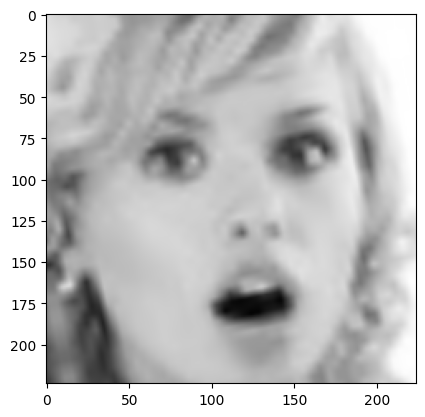

In [29]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224, 224, 3))

In [30]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)
image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 38.7 ms, sys: 2.9 ms, total: 41.6 ms
Wall time: 38.8 ms
(32, 224, 224, 3)
(32, 7)


In [31]:
#building efficientNet model
from tensorflow.keras.applications import EfficientNetV2B2

backbone = EfficientNetV2B2(
    input_shape=(96,96,3),
    include_top=False)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ ?                      │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [32]:
#compiling your model by providing the optimizer, loss and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)